In [82]:
# Import all necesary libraries for completing the fine-tuning transfer learning task

from keras.models import load_model, Model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import initializers, regularizers
K.set_image_data_format('channels_last')
import numpy as np
from skimage import transform, io
import tensorflow as tf
from sklearn.model_selection import train_test_split
import h5py
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from collections import Counter

In [ ]:
# Return an encoding dict which maps the
def get_unique_encoding_for_labels(label_list):
    unique_labels = list(set(label_list))
    label_encoding_dict = {k : int(unique_labels.index(k)) for k in unique_labels}
    
    return label_encoding_dict

In [1]:
# Function to read csv file with labels and return 2 dictionaries which give the key pair values of 
# the file names to the text labels(breed of the dog) and another mapping the text label to a unique encoding integer
def load_csv_as_dict(filePath):
    key_values = np.genfromtxt(filePath, names = True, dtype = None).astype(str)
    label_dict = {k.split(",")[0] : k.split(",")[1] for k in key_values}
    label_encoding_dict = get_unique_encoding_for_labels(list(label_dict.values()))
    
    
    return label_dict, label_encoding_dict

In [ ]:
# Get the 2 dictionaries
label_dict, label_encoding_dict = load_csv_as_dict('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/labels.csv')

In [ ]:
# Get the name of the files and their complete paths in the same order as read
# We extract the name of the files so as to get their corresponding class labels in the same order later
def get_file_path_list(directory):
    file_paths = [join(directory, f) for f in listdir(directory) if isfile(join(directory, f))]
    file_names = [f.split("/")[-1].split(".")[0] for f in file_paths]
    
    return file_names, file_paths

In [ ]:
# Get the 2 lists with the file names and paths
file_names, file_path_list = get_file_path_list('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/train')
print(file_names[0])
print(file_path_list[0])

In [ ]:
# Same functions and their corresponding purposes as defined above, the only difference being that instead of 
# reading all the possible labels we read only the most frequent 16 classes
# This is done because the original dataset has 120 labels and almost 10,000 images which is far beyond
# the processing capabilities of my CPU, which is why I instead chose to take only 16 labels for quicker computation
# -------------------------------------------------------

In [67]:

def get_unique_encoding_for_labels_(label_list):
    count = Counter(label_list).most_common(16)
    top16 = [k[0] for k in count]
    label_encoding_dict = {k : int(top16.index(k)) for k in top16} 
    
    
    
    return label_encoding_dict, top16

In [68]:
def load_csv_as_dict_(filePath):
    key_values = np.genfromtxt(filePath, names = True, dtype = None).astype(str)
    key_values_list = [(k.split(",")[0], k.split(",")[1]) for k in key_values]
    label_list = [k[1] for k in key_values_list]
    label_encoding_dict, top16 = get_unique_encoding_for_labels_(label_list)
    label_dict = {k[0]:k[1] for k in key_values_list if k[1] in top16}
    
    return label_dict, label_encoding_dict

In [69]:
label_dict, label_encoding_dict = load_csv_as_dict_('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/labels.csv')

In [70]:
def get_file_path_list_(directory):
    file_paths = [join(directory, f) for f in listdir(directory) if (isfile(join(directory, f)) and f.split(".")[0] in label_dict)]
    file_names = [f.split("/")[-1].split(".")[0] for f in file_paths]
    
    return file_names, file_paths

In [71]:
file_names, file_path_list = get_file_path_list_('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/train')

In [ ]:
# -------------------------------------------------------

In [73]:
# Read the images given in the file path list into a numpy array and resize them to (224,224)(default size for VGG-19)
# so that all images are of the same size and can be concatenated into one numpy array without any issues
def read_image(image_location):
    image_list = io.imread_collection(image_location)
    resized_image_list = [transform.resize(x, (224,224)) for x in image_list]
    image_array = np.array(resized_image_list, dtype = 'float32') # This is done to save on size (less space than fl64)
    
    return image_array

In [141]:
# Note that if your system is prone to unexpected crashes like mine, it is always a good practice to save the 
# translated numpy arrays so that they can be easily loaded later in case of a crash, thus saving a lot of time

#X_train_orig = read_image(file_path_list)
#np.save('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/X_train_orig', X_train_orig)
X_train_orig = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/X_train_orig.npy')
#X_train = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/Xtrainnumpy.npy')
print(X_train_orig.shape) # Check if dimensions match the size of the training dataset

(1777, 224, 224, 3)

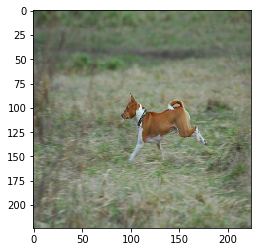

In [142]:
# Test if the images in the numpy array have been loaded correctly
plt.imshow(X_train_orig[300], cmap = plt.get_cmap('gray')) # use matplotlib to show image
plt.show()

In [78]:
# For training keras needs the labels to be in a one hot form, i.e a 1 at the index of the class label and the rest 0's
def convert_to_one_hot(Y, C):
    Y = np.eye(C, dtype = 'uint8')[Y]
    return Y

In [79]:
Y_train_orig = [label_encoding_dict[label_dict[l]] for l in file_names] # Get encoding number for classes 
Y_train_one_hot = convert_to_one_hot(Y_train_orig, len(label_encoding_dict)) # Given the encoding numbers conver to one-hot form
print(Y_train_one_hot.shape) #Check if shape is correct it should be (no. of examples  * no. of total labels)

(1777, 16)

In [143]:
#np.save('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/Y_train_orig', Y_train_one_hot)
Y_train_one_hot = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/Y_train_orig.npy')

In [144]:
# A great function provided in sk learn to split a dataset into training dataset/labels and validation dataset/labels
# The test_size determines the size of the validation dataset, i.e 0.2 would mean a 20%/80% split for the train/val datsets

X_train, X_val, Y_train, Y_val = train_test_split(X_train_orig, Y_train_one_hot, test_size = 0.2, random_state = 42)

In [255]:
#np.save('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/X_train', X_train)
X_train = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/X_train.npy')
X_train.shape

(1421, 224, 224, 3)

In [256]:
#np.save('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/X_val', X_val)
X_val = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/X_val.npy')

In [257]:
#np.save('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/Y_train', Y_train)
Y_train = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/Y_train.npy')

In [258]:
#np.save('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/Y_val', Y_val)
Y_val = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/Y_val.npy')

In [ ]:
# --- Withput computing bottleneck feature vectors -------------------------

In [87]:
# Decide a batch_size,a realtively small power of 2 is usually a good choice,as conventional processors usually find it
# Easy to handle power of 2's due to their architecture

batch_size = 32

# Load the model along with its weights and input shape from Keras
# We will be using the pre-computed weights for the imagenet challenge as we can take benefit of all the low-level 
# and high-level features computed which might help in detcting dogs,as the imagenet dataset has already been trained 
# on thousands of dog pictures
# We use include_top=False as this instructs keras not to load the weights for the FC layers,as our ouptut softmax 
# is different compared to the ImageNet challenge, we will instead learn these parameters

base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [ ]:
# This lets you see a summary of the model and check if all the output shapes are to your liking
base_model.summary()

In [93]:
# Now the next step is to add the FC layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(16, activation='softmax')(x) # Softmax to predict the probabilites of each of the 16 classses
model = Model(inputs=base_model.input, outputs=predictions)

In [94]:
# Instructs keras that all the layers before the FC layers do not need to be trained
# Thus only the weights for the FC layers will be learnt
for layer in base_model.layers:
    layer.trainable = False

In [95]:
# An extremely powerful generator provided by keras which provides an infinite supply of batches
# and makes sure that each image seen by the CNN in an epoch is different i.e a transform of the original image
# So that the CNN learns new features and learns to become invariant to certain transformations
# It is in short a very powerful method for data augmentation

datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [96]:
# Compile the model
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [2]:
# Train the compiled model above
epochs = 30
# Check Keras documentation for better understanding of Image Generators and flow 
model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                   steps_per_epoch = X_train.shape[0] // batch_size, 
                   epochs=epochs,
                   validation_data=(X_val,Y_val))

In [ ]:
# -----------------------------------------------------

In [ ]:
# ------ Using bottleneck features -------------------------------------------

In [2]:
# Assign batch_size and epochs
batch_size = 32
epochs = 50

In [146]:
def save_bottleneck_features():

    # build the VGG19 network|
    model = VGG19(include_top=False, weights='imagenet')
    
    # Run the Training dataset through the VGG19 network without the FC layers to get a set of feature vectors
    bottleneck_features_train = model.predict(X_train, batch_size=batch_size, verbose=1)
    np.save(('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/bottleneck_features_train_0.1'),bottleneck_features_train)

    # Do the same computation for the Validation dataset to get a set of feature vectors 
    bottleneck_features_validation = model.predict(X_val, batch_size=batch_size, verbose=1)
    np.save(('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/bottleneck_features_validation_0.1'),bottleneck_features_validation)

In [147]:
# Run the bottleck feature function, the output will have the computed feature vectors for both the training and val datasets
save_bottleneck_features()

178/178 [==============================] - 100s 561ms/step
Done


In [289]:
def train_top_model():
    # We do not need the VGG 19 model any longer as we have already computed the forward-propogation feature vectors
    # of the images in our dataset
    
    # Load the train and val feature vector dataset, now this will be our new training and validation dataset
    train_data = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/bottleneck_features_train.npy')
    train_labels = Y_train

    validation_data = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/bottleneck_features_validation.npy')
    validation_labels = Y_val

    # This denotes that we will be using the Sequential API of Keras rather than the functional one
  
    model = Sequential()
    # Add whatever layers you wnat to improve performance
    
    #model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
    #model.add(Dense(256, activation='relu', kernel_initializer = initializers.he_uniform()))
    #model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer = initializers.he_uniform()))
    #model.add(Dropout(0.3))
    model.add(Dense(16, activation='softmax', kernel_initializer = initializers.he_uniform()))
    
    # Compile the model using parameters of your choice
    model.compile(optimizer = "Nadam", loss = "categorical_crossentropy", metrics = ["accuracy"])

    # Train the compiled model
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels), verbose=1)
    model.save('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/final_model.h5')

In [290]:
train_top_model()
# Clearly the model is overfitting, this means that the model that we have learnt is too powerful, because of which
# It is easily able to classify trained examples, but not able to generalize to the examples that it has not seen
# You could try using techniques like regularization, aggresive dropout, data augmentation, or in some cases
# reducing the size of the training dataset and isntead incresae the size of the validation set or use early-stopping
# Although I do not recommend both of these techniques

Train on 1421 samples, validate on 356 samples
Epoch 1/50
1421/1421 [==============================] - 3s 2ms/step - loss: 2.6435 - acc: 0.1443 - val_loss: 2.5215 - val_acc: 0.1742
Epoch 2/50
1421/1421 [==============================] - 0s 262us/step - loss: 2.1602 - acc: 0.3019 - val_loss: 2.2382 - val_acc: 0.2584
Epoch 3/50
1421/1421 [==============================] - 0s 260us/step - loss: 1.8524 - acc: 0.4046 - val_loss: 2.1142 - val_acc: 0.2612
Epoch 4/50
1421/1421 [==============================] - 0s 272us/step - loss: 1.6665 - acc: 0.4673 - val_loss: 1.9427 - val_acc: 0.3399
Epoch 5/50
1421/1421 [==============================] - 0s 280us/step - loss: 1.5171 - acc: 0.5081 - val_loss: 1.6751 - val_acc: 0.4410
Epoch 6/50
1421/1421 [==============================] - 0s 281us/step - loss: 1.3733 - acc: 0.5665 - val_loss: 1.6582 - val_acc: 0.4522
Epoch 7/50
1421/1421 [==============================] - 0s 275us/step - loss: 1.2972 - acc: 0.5954 - val_loss: 1.9285 - val_acc: 0.3736
Epo

In [84]:
final_model = load_model('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/final_model.h5')
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 16)                8208      
Total params: 12,853,776
Trainable params: 12,853,776
Non-trainable params: 0
_________________________________________________________________


In [85]:
val_data = np.load('/Users/Madhav/Desktop/ML Projects/Kaggle/Dog Breed/top16/bottleneck_features_validation.npy')

In [111]:
# Get predicted class numbers for validation data
t1 = final_model.predict_classes(val_data)

In [110]:
# Get truth value of class numbers from Y_val
t2 = np.argmax(Y_val, axis=1)

In [115]:
# Check if both arrays are equal
t3 = (t1 == t2).astype(int)

In [121]:
# Return index of elements where prediction != truth value
# I.e. return index of misclassified examples
# This is an extremely powerful technique to improve performance as by manually inspecting some misclassified examples
# One can try to understand why the exapmles are being misclassified
np.where(t3 == 0)

(array([  0,   3,   6,   7,   8,   9,  11,  13,  14,  17,  18,  19,  22,
         24,  26,  28,  29,  32,  33,  34,  36,  39,  40,  42,  46,  47,
         48,  53,  56,  57,  59,  60,  62,  64,  65,  66,  75,  77,  78,
         83,  86,  91,  92,  93,  94, 102, 106, 107, 109, 113, 114, 116,
        119, 124, 125, 126, 129, 131, 132, 133, 135, 137, 140, 141, 142,
        144, 146, 147, 151, 152, 153, 155, 156, 158, 159, 160, 161, 162,
        164, 166, 169, 176, 178, 179, 180, 183, 187, 189, 191, 194, 200,
        201, 203, 207, 209, 212, 215, 216, 220, 223, 226, 228, 229, 230,
        231, 232, 233, 234, 236, 237, 242, 244, 246, 251, 253, 254, 256,
        257, 259, 262, 265, 266, 268, 271, 273, 275, 277, 282, 284, 286,
        289, 291, 292, 294, 295, 298, 305, 306, 307, 308, 311, 312, 314,
        319, 321, 322, 324, 326, 328, 330, 331, 332, 334, 336, 337, 343,
        344, 349, 350, 351, 352, 354, 355]),)

In [124]:
t1

array([10, 12,  4,  2, 11,  5, 10, 15, 10,  7,  3,  7,  1, 11,  7,  6,  1,
        1,  5, 12,  0, 12,  5,  8,  7, 13, 10,  6, 15,  1,  6, 10, 11,  6,
        5, 14,  6, 10, 14,  3,  5,  4,  0,  7,  9,  3,  7, 13, 15,  6, 15,
        6,  5,  1, 14,  6, 14,  8, 11,  6, 11, 15,  1, 15,  5,  6, 15,  0,
       15,  7,  1,  7,  8, 12, 11,  9,  4, 13, 10,  2,  4,  2,  0,  4,  3,
        0, 13,  6,  6,  9,  1,  4,  9,  9,  0,  2,  1, 14,  0, 11,  3,  5,
       12,  2, 14,  1, 15,  1,  9, 12, 12,  9,  1,  8,  9, 13, 10,  5, 11,
       15, 10,  1,  2,  9, 14, 13,  7,  2, 10, 10,  8,  8, 14,  4,  2,  5,
        0,  7, 13,  8,  5,  0,  2,  9,  0, 13, 12,  4,  9, 12,  3, 12, 10,
       12,  2, 12,  8, 12,  5, 15,  4, 10, 15,  7,  9,  4, 12, 15,  9,  9,
       11,  9,  6,  2, 14,  5,  5, 10, 12, 15,  5, 13,  4, 10,  1,  5,  0,
       13, 15, 10,  3,  5, 12, 11,  5,  8,  9,  3, 13, 11,  5,  6, 14,  0,
        5, 13,  8, 15,  2,  7,  7,  3,  1,  9, 15, 15,  5,  3,  3,  9, 10,
       13,  7,  9, 14, 10

In [125]:
t2

array([ 9, 12,  4, 10, 11,  5,  6,  7,  5,  6,  3,  5,  1,  2,  6,  6,  1,
        7,  7, 10,  0, 12, 15,  8,  6, 13, 11,  6, 11, 11,  6, 10,  1, 12,
       12, 14,  9, 10, 14,  4,  1,  4, 13,  7,  9,  3,  1,  8,  3,  6, 15,
        6,  5,  7, 14,  6,  8,  9, 11,  9,  5, 15, 15, 15,  1,  9,  1,  0,
       15,  7,  1,  7,  8, 12, 11,  7,  4,  7, 11,  2,  4,  2,  0,  7,  3,
        0, 10,  6,  6,  9,  1,  0,  7, 13,  5,  2,  1, 14,  0, 11,  3,  5,
        0,  2, 14,  1,  4, 14,  9,  5, 12,  9,  1,  4,  6, 13,  2,  5, 11,
        8, 10,  1,  2,  9, 15,  0,  9,  2, 10, 12,  8,  6,  4,  3,  2, 14,
        0,  3, 13,  8, 11, 10,  8,  9,  2, 13,  6, 10,  9, 12,  3,  0,  1,
        5,  2,  6, 15, 12,  6,  7, 15,  7,  3,  7, 11,  4,  1, 15,  9,  7,
       11,  9,  6,  2, 14,  5,  1, 10, 10,  3, 10, 13,  4,  9,  1,  5,  0,
       10, 15,  7,  3, 11, 12, 11,  1,  8,  9,  3, 13, 11,  7,  1, 14, 10,
        5, 13,  8,  2,  2, 12,  7,  3, 12,  9, 15,  8,  7,  3,  3,  9, 13,
       13,  7,  2, 14, 10

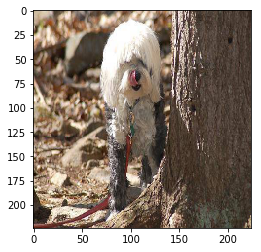

In [138]:
plt.imshow(X_val[26], cmap = plt.get_cmap('gray')) # use matplotlib to show image
plt.show()